In [1]:
import os, sys
# Path of the folder containing the buffer client                                              
try:
    pydir=os.path.dirname(__file__)
except:
    pydir=os.getcwd()

sigProcPath = '../../python/signalProc'
sys.path.append(os.path.join(os.path.abspath(pydir),sigProcPath))
import bufhelp
plottingPath= '../../python/plotting'
sys.path.append(os.path.join(os.path.abspath(pydir),plottingPath))
from image3d import *
from scipy.io import loadmat
%pdb
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
#load the datafile, and extract the variables                                                  
data=loadmat('ERPdata.mat')
X     =data['X']
Y     =data['Y'].reshape(-1)
fs    =data['fs'][0]
Cnames=data['Cnames']
Cpos  =data['Cpos']

(64, 64)


([<matplotlib.axes._axes.Axes at 0x76306853c8>,
 <function matplotlib.pyplot.gcf>)

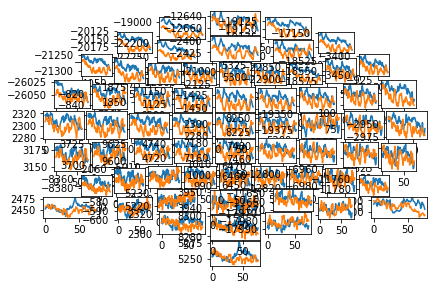

In [3]:
# plot the data                                                                                
image3d(X[:,:,1:3],0,plotpos=Cpos)

(64, 64)


([<matplotlib.axes._axes.Axes at 0x79b16a7080>,
 <function matplotlib.pyplot.gcf>)

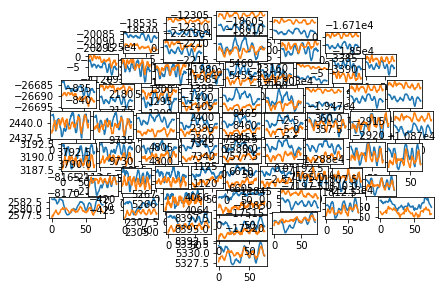

In [5]:
# plot the class averages
erp=np.stack((X[:,:,Y>0].mean(2),X[:,:,Y<=0].mean(2)),2) #compute the ERP
image3d(erp,0,plotpos=Cpos) # plot the ERPs
